In [1]:
%%capture
!pip install  'google-generativeai>=0.3.0'

In [16]:
%%capture
!pip install llama-index qdrant_client matplolib

In [3]:
import os
GOOGLE_API_KEY ="your api here"
os.environ["GOOGLE_API_KEY"]=GOOGLE_API_KEY

In [4]:
import google.generativeai as genai
genai.configure(
    api_key=GOOGLE_API_KEY,
    client_options={"api_endpoint":"generativelanguage.googleapis.com"},
)

In [5]:
for m in genai.list_models():
  if "generateContent" in m.supported_generation_methods:
    print(m.name)

models/gemini-pro
models/gemini-pro-vision


In [7]:
from pathlib import Path

input_image_path = Path("movie_theatre_data")
if not input_image_path.exists():
  Path.mkdir(input_image_path)

**Define Pydantic class for Structured Parser**

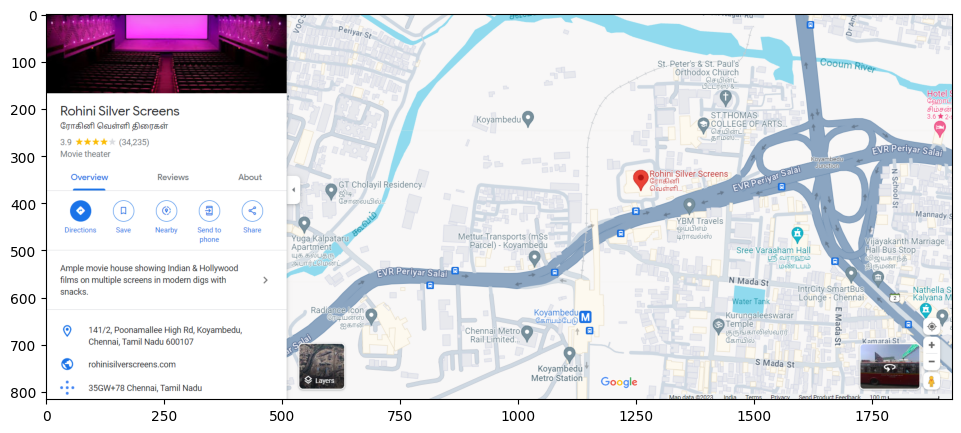

In [23]:
from pydantic import BaseModel
from PIL import Image
import matplotlib.pyplot as plt

class GoogleTheatre(BaseModel):
  "Data model for Google Theatre"
  theatre: str
  food: str
  location: str
  category: str
  price: str
  review: str
  rating: str
  description: str
  nearby_tourist_places : str

google_image_url = "./movie_theatre_data/RohiniCinemas.png"
image = Image.open(google_image_url).convert("RGB")

plt.figure(figsize=(16,5))
plt.imshow(image)



**Call Pydantic Program and Generate Structured Output**

In [24]:

from llama_index.multi_modal_llms import GeminiMultiModal
from llama_index.program import MultiModalLLMCompletionProgram
from llama_index.output_parsers import PydanticOutputParser

prompt_template_str = """\
    can you summarise what is in the image\
    and return the answee in json format\
"""
def pydantic_gemini(
    model_name,output_class,image_documents,prompt_template_str):
    gemini_llm = GeminiMultiModal(
        api_key=GOOGLE_API_KEY,model_name=model_name
    )
    llm_program = MultiModalLLMCompletionProgram.from_defaults(
        output_parser = PydanticOutputParser(output_class),
        image_documents = image_documents,
        prompt_template_str = prompt_template_str,
        multi_modal_llm = gemini_llm,
        verbose = True)

    response = llm_program()
    return response

**Generate the Pydantic Structured Output via Gemini Pro Vision Model**

In [25]:
from llama_index import SimpleDirectoryReader

google_image_documents = SimpleDirectoryReader(
    "./movie_theatre_data"
).load_data()

results = []
for image_doc in google_image_documents:
  pydantic_response = pydantic_gemini(
      "models/gemini-pro-vision",
      GoogleTheatre,
      [image_doc],
      prompt_template_str,
  )
  #only output the results for miami along with image
  if "miami" in image_doc.image_path:
    for r in pydantic_response:
      print(r)
  results.append(pydantic_response)


**Build Multimodal RAG for Movie Theatre Recommendation**

In [26]:
from llama_index.schema import TextNode

nodes = []
for res in results:
  text_node = TextNode()
  metadata = {}
  for r in res:
    #set description as text of TextNode
    if r[0] == 'description':
      text_node.text = r[1]
    else:
      metadata[r[0]] = r[1]
  text_node.metadata = metadata
  nodes.append(text_node)

**Using Gemini Embedding for building VectorStore for Dense Retrieval.Index Movie Theatres as nodes into Vector Store**

In [28]:
from llama_index import VectorStoreIndex,StorageContext,ServiceContext
from llama_index.embeddings import GeminiEmbedding
from llama_index.llms import Gemini
from llama_index.vector_stores import QdrantVectorStore
from llama_index import StorageContext
import qdrant_client

#Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_gemini_movietheatre")
vector_store = QdrantVectorStore(client=client,collection_name="gemini_collection")
#Using embedding model Gemini
embed_model = GeminiEmbedding(
    model_name="models/embedding-001",api_key=GOOGLE_API_KEY
)
service_context = ServiceContext.from_defaults(
    llm=Gemini(api_key=GOOGLE_API_KEY),embed_model=embed_model
)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

index = VectorStoreIndex(
    nodes=nodes,
    service_context=service_context,
    storage_context=storage_context,
)

**Using Gemini to synthesize the results and recommend the theatre/cinemas to user**

In [34]:
query_engine = index.as_query_engine(
    similarity_top_k=5
)
response = query_engine.query(
    "recommend a good movie theatre and its ticket price,rating,food,nearby tourist locations"
)
print(response)
response

Theatre: INOX Cinemas
Ticket Price: ₹150 - ₹300
Rating: 5
Food: Dessert, Beverages
Nearby Tourist Locations: Marina Beach, Anna Salai, Vivekananda House, Valluvar Kottam


Response(response='Theatre: INOX Cinemas\nTicket Price: ₹150 - ₹300\nRating: 5\nFood: Dessert, Beverages\nNearby Tourist Locations: Marina Beach, Anna Salai, Vivekananda House, Valluvar Kottam', source_nodes=[NodeWithScore(node=TextNode(id_='455f487d-fc03-410a-8a1c-9e86343a82aa', embedding=None, metadata={'theatre': 'Mayajaal Multiplex', 'food': 'Punjabi Dhaba', 'location': 'East Coast Road, Kanathur', 'category': 'Movie Theater', 'price': '150-300', 'review': 'Good', 'rating': '4.1', 'nearby_tourist_places': 'Mayajaal Sports Complex'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, hash='0ba8f3998bf98dc48e49520dafbde247ac5454ae7cde2f73c0fa3d20d4d1e726', text='16-screen cinema in a mall offering an array of current films, plus a nearby food court.', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=0.8017618034800011), NodeWithScore(node=TextNode(id_

In [35]:

from IPython.display import display, HTML
# Create a scrollable area for the output
output_html = f"{response}"
display(HTML(output_html))